# Product Sentiment Classification 

1. Introduction

Sentiment classification is text classification problem which deals with classified sentiments based on opinion recorded. The objective here is to build a model which learns form classified product reviews and predict the sentiment of the review that lies in the range 1 to 5. The following provides step-by-step text classification carried out throughout the notebook.

# Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import nltk
import re
from nltk.tokenize import RegexpTokenizer
from os import path
from nltk.tokenize import word_tokenize
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
from spellchecker import SpellChecker
from textblob import TextBlob, Word, Blobber
import plotly.tools as tls
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import chart_studio.plotly as py
from textblob import Word
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

# Loading data

In [2]:
train = pd.read_csv("E:/Garima folder/Participants_Data/Train.csv")
test = pd.read_csv("E:/Garima folder/Participants_Data/Test.csv")

In [3]:
# Working on required set of variables in the dataset
train = train[['Product_Description','Product_Type','Sentiment']]

In [4]:
train.columns

Index(['Product_Description', 'Product_Type', 'Sentiment'], dtype='object')

In [5]:
train.head()

,Product_Description,Product_Type,Sentiment
0,The Web DesignerÛªs Guide to iOS (and Android...,9,2
1,RT @mention Line for iPad 2 is longer today th...,9,2
2,Crazy that Apple is opening a temporary store ...,9,2
3,The lesson from Google One Pass: In this digit...,9,2
4,RT @mention At the panel: &quot;Your mom has a...,9,2


In [6]:
test.head()

,Text_ID,Product_Description,Product_Type
0,5786,RT @mention Going to #SXSW? The new iPhone gui...,7
1,5363,RT @mention 95% of iPhone and Droid apps have ...,9
2,6716,RT @mention Thank you to @mention for letting ...,9
3,4339,#Thanks @mention we're lovin' the @mention app...,7
4,66,At #sxsw? @mention / @mention wanna buy you a ...,9


# EXPLORATORY DATA ANALYSIS:

* Exploring the complete dataset to understand all the feature and the dependent variable to analyze dataset in better fashion.The Exploratory Data Analysis is very essential step to visualize, summarize, and interpret the information that is invisible in the rows and columns of the Data.It is the initial investigating process to analyze datase

In [7]:
print(train.shape)

(6364, 3)


In [8]:
train['Sentiment'].value_counts()

2    3765
3    2089
1     399
0     111
Name: Sentiment, dtype: int64

In [9]:
# The previous counts can be simply visualized using plotting the Review Rating distribution of data in form of barplot.
train['Sentiment'].iplot(kind='hist',xTitle='Sentiment Rating',linecolor='black',legend=dict(),yTitle='Count',
                         title='Sentiments Review Rating Distribution')

* The plot demonstrates that Sentiment Rating is Left-skewed.
* The class '2' Sentiments are highest in number that is the positively number of revies for the product is there in the dataset.

In [10]:
#Calculating POLARITY of SENTIMENTS , Review Length and Word Count of each review.

train['Sentiment Polarity'] = train['Product_Description'].map(lambda Product_Description: TextBlob(Product_Description).sentiment.polarity)
train['Review Length'] = train['Product_Description'].astype(str).apply(len)
train['Word Count'] = train['Product_Description'].apply(lambda x: len(str(x).split()))
train.head()

,Product_Description,Product_Type,Sentiment,Sentiment Polarity,Review Length,Word Count
0,The Web DesignerÛªs Guide to iOS (and Android...,9,2,0.0,89,15
1,RT @mention Line for iPad 2 is longer today th...,9,2,0.3,119,23
2,Crazy that Apple is opening a temporary store ...,9,2,-0.6,111,20
3,The lesson from Google One Pass: In this digit...,9,2,0.0,137,22
4,RT @mention At the panel: &quot;Your mom has a...,9,2,0.0,87,14


In [11]:
#Plotting the Sentiment Polarity of each document using iplot

train['Sentiment Polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='Polarity of Reviews',
    linecolor='black',
    legend=dict(),
    yTitle='Count',
    title='Sentiment Polarity Distribution before Text Processing')

In [12]:
#Plotting the review length of each document using iplot

train['Review Length'].iplot(
    kind='hist',
    bins=100,
    xTitle='Review length',
    linecolor='black',
    legend=dict(),
    yTitle='count',
    title='Review Text Length Distribution')

In [13]:
#Plotting the Word count of each document using iplot.
train['Word Count'].iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    legend=dict(),
    yTitle='count',
    title='Review Text Word Count Distribution')

No handles with labels found to put in legend.


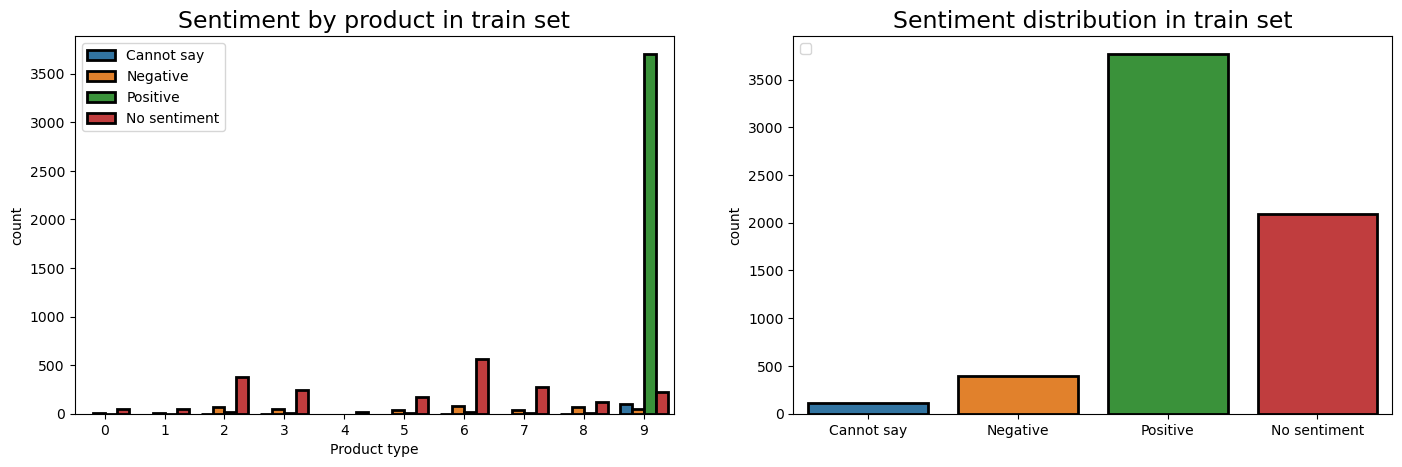

In [14]:
import seaborn as sns
fig,ax = plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(17,5))
sns.countplot(data=train,x="Product_Type",hue="Sentiment",edgecolor="black",ax=ax[0],linewidth=2)
ax[0].legend(loc="upper left",labels=["Cannot say","Negative","Positive","No sentiment"])
ax[0].set_title('Sentiment by product in train set',size=17)
ax[0].set_xlabel("Product type")


sns.countplot(data=train,x="Sentiment",edgecolor="black",ax=ax[1],linewidth=2)
ax[1].legend(loc="upper left")
ax[1].set_title('Sentiment distribution in train set',size=17)
ax[1].set_xticklabels(["Cannot say","Negative","Positive","No sentiment"])
ax[1].set_xlabel("")

plt.show()

# TEXT PRE-PROCESSING:


* Data Cleaning is a process of cleaning the data according to our model requirements and situation.

A solution may not need all the data we received ,and have to -
* remove columns, modify columns,remove duplicate values,
* deal with missing values,
* deal with outlier data etc.
* Sometimes we will also need to normalize or scale data to make the data fit within a range. This process in general is known as Data Cleaning.

In [15]:
test_str = train.loc[0, 'Product_Description']

def clean_text(text):
    text = re.sub(r'\n',' ', text)
    text=  re.sub('@mention',' ', text )
    text=  re.sub('{link}',' ', text )
    text=  re.sub('Ûª',' ', text )
    text=  re.sub('  ',' ', text )
    text=  re.sub('RT',' ', text )
    text=  re.sub('//',' ', text )
    text=  re.sub('&quot',' ', text )
    text=  re.sub('&amp',' ', text )
    text=  re.sub(r'[^\w\s]',' ', text )
    text=  re.sub(' +',' ', text )
    text = re.sub(r'@\w+'," ",text)
    text = re.sub(r'[^a-zA-Z]'," ",text)
    text = re.sub(r' [a-zA-Z]{1} '," ",text)
    return text

def process_text(df):
    df['description'] = df['Product_Description'].apply(lambda x: clean_text(x))
    return df

print("Original text: " + test_str)
print("Cleaned text: " + clean_text(test_str))

Original text: The Web DesignerÛªs Guide to iOS (and Android) Apps, today @mention 10 a.m! {link} #sxsw
Cleaned text: The Web Designer Guide to iOS and Android Apps today    m sxsw


In [16]:
train = process_text(train)
test = process_text(test)
train.drop('Product_Description',1,inplace=True)
test.drop('Product_Description',1,inplace=True)


In [17]:
train.head(3)

,Product_Type,Sentiment,Sentiment Polarity,Review Length,Word Count,description
0,9,2,0.0,89,15,The Web Designer Guide to iOS and Android Apps...
1,9,2,0.3,119,23,Line for iPad is longer today than yesterda...
2,9,2,-0.6,111,20,Crazy that Apple is opening temporary store in...


In [18]:
test.head(3)

,Text_ID,Product_Type,description
0,5786,7,Going to SXSW The new iPhone guide to Austin ...
1,5363,9,of iPhone and Droid apps have less than ...
2,6716,9,Thank you to for letting me test drive car to...


In [19]:
data= train['description'].to_string()

In [20]:
# Sentence Tokenization
from nltk.tokenize import sent_tokenize
tokens = sent_tokenize(data)

In [21]:
# Word Tokenization
from nltk.tokenize import word_tokenize
tokens = nltk.word_tokenize(data)
#tokens

In [22]:
from nltk.probability import FreqDist
fdist = FreqDist(tokens)
print(fdist)
fdist.most_common(10)

<FreqDist with 13581 samples and 66750 outcomes>


[('...', 5800),
 ('the', 1626),
 ('to', 1482),
 ('SXSW', 1375),
 ('Google', 1197),
 ('at', 1137),
 ('sxsw', 958),
 ('Apple', 953),
 ('iPad', 892),
 ('for', 864)]

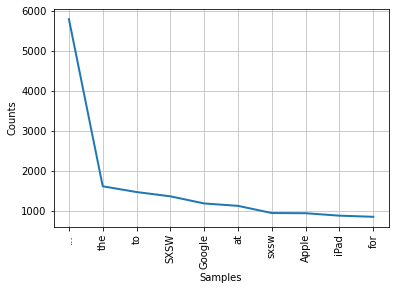

In [23]:
import matplotlib.pyplot as plt
fdist.plot(10,cumulative=False)
plt.show()

In [24]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'/[^a-zA-Z ]/|\w+')
t=tokenizer.tokenize(data)
# convert to lower case
tokens = [w.lower() for w in t]
#tokens

In [25]:
# remove remaining tokens that are not alphabetic
words = [word for word in tokens if word.isalpha()]
#words

In [26]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
#stop_words

In [27]:
words = [w for w in words if not w in stop_words]
#print(words)

In [28]:
from nltk.stem.wordnet import WordNetLemmatizer
lemma = WordNetLemmatizer()
words = [lemma.lemmatize(w,"v") for w in words]
#words

In [29]:
from nltk.probability import FreqDist
fdist = FreqDist(words)
print(fdist)

<FreqDist with 4886 samples and 35251 outcomes>


In [30]:
fdist.most_common(20)

[('sxsw', 2402),
 ('google', 1391),
 ('apple', 1131),
 ('ipad', 1063),
 ('new', 573),
 ('store', 567),
 ('iphone', 533),
 ('launch', 413),
 ('app', 357),
 ('social', 327),
 ('pop', 319),
 ('open', 293),
 ('austin', 293),
 ('get', 275),
 ('line', 237),
 ('go', 223),
 ('network', 211),
 ('android', 193),
 ('major', 189),
 ('party', 164)]

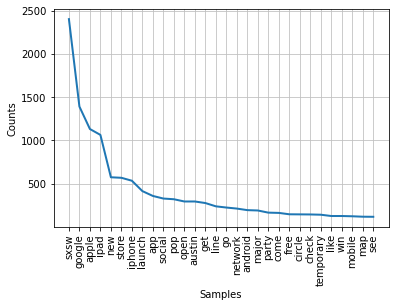

In [31]:
import matplotlib.pyplot as plt
fdist.plot(30,cumulative=False)
plt.show()

In [32]:
#Calculating Sentiment polarity after Text cleaning.
train['Sentiment Polarity 2'] = train['description'].map(lambda text: TextBlob(text).sentiment.polarity)

In [33]:
train['Sentiment Polarity 2'].iplot(
    kind='hist',
    bins=50,
    xTitle='Polarity',
    linecolor='black',
    legend=dict(),
    yTitle='Count',
    title='Sentiment Polarity Distribution After Text Processing')

# MODEL FITTING

In [36]:
from sklearn.model_selection import train_test_split

X = train['description']
y = train['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### MULTINOMIAL LOGISTIC REGRESSION ON UNIGRAM MODEL:

* Multinomial logistic regression is used when the dependent variable in question is nominal (equivalently categorical, meaning that it falls into any one of a set of categories that cannot be ordered in any meaningful way) and for which there are more than two categories.

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
vectorizer=CountVectorizer(ngram_range = (1,1))
count_train=vectorizer.fit_transform(X_train.values)
count_test=vectorizer.transform(X_test.values)

In [38]:
# Multinomial Logistic regression model
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg',C=0.6, 
                                         class_weight="balanced", fit_intercept=False,
                                         max_iter=250, penalty='l2',tol=0.0001).fit(count_train,y_train)

In [39]:

# cross validation score
scores = cross_val_score(mul_lr, count_train, y_train, cv=3)
scores

array([0.61697113, 0.62639953, 0.60636417])

In [40]:
#test the model to predict the test set.
pred = mul_lr.predict(count_test)

# determine the accuracy
metrics.accuracy_score(y_test,pred)

0.6425765907305577

### MULTINOMIAL LOGISTIC REGRESSION ON BIGRAM MODEL:

In [41]:
count=CountVectorizer(ngram_range=(1,2))
Bigram_train=count.fit_transform(X_train.values)
Bigram_test=count.transform(X_test.values)

In [42]:
# Multinomial Logistic regression model
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg',C=0.6, 
                                         class_weight="balanced", fit_intercept=False,
                                         max_iter=250, penalty='l2',tol=0.0001).fit(Bigram_train,y_train)

In [43]:
# cross validation score
scores = cross_val_score(mul_lr, Bigram_train, y_train, cv=3)
scores

array([0.65586329, 0.65350619, 0.64289923])

In [44]:
#test the model to predict the test set.
pred = mul_lr.predict(Bigram_test)

# determine the accuracy
metrics.accuracy_score(y_test,pred)

0.6692851531814611

### MULTINOMIAL LOGISTIC REGRESSION ON TF-IDF VECTOR MODEL:

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer()
tf_train = tf.fit_transform(X_train.values)
tf_test = tf.transform(X_test.values)

In [46]:
# Multinomial Logistic regression model
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg',C=0.6, 
                                         class_weight="balanced", fit_intercept=False,
                                         max_iter=250, penalty='l2',tol=0.0001).fit(tf_train,y_train)

In [47]:
# cross validation score
scores = cross_val_score(mul_lr, tf_train, y_train, cv=3)
scores

array([0.59634649, 0.57748969, 0.57218621])

In [48]:
#test the model to predict the test set.
pred = mul_lr.predict(tf_test)

# determine the accuracy
metrics.accuracy_score(y_test,pred)

0.6001571091908877

## CONCLUSION

### __Metrics__:

* 1.__MULTINOMIAL LOGISTIC REGRESSION ON UNIGRAM MODEL__ - Accuracy:0.64257
* 2.__MULTINOMIAL LOGISTIC REGRESSION ON BIGRAM MODEL__ - Accuracy:0.66928
* 3.__MULTINOMIAL LOGISTIC REGRESSION ON TF-IDF VECTOR MODEL__ - Accuracy:0.60015


* We have successufully modeled the text classifier to predict the sentiment of a product review. We have performed the following steps:

Text pre-processing to regularise words for analysis
* Performed feature generation to extract potential features for the model.
* Multinomial Logistic regression
* Convenient probability scores for observations
* Efficient implementations available across tools
* Multi-collinearity is not really an issue
* can be countered with L2 regularization to an extent
* Wide spread industry comfort for logistic regression solutions


* We have arrived at an accuracy of 66.9% on the test data when the model was trained on 'MULTINOMIAL LOGISTIC REGRESSION ON BIGRAM MODEL'.